# Imports

In [121]:
# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate

# Local imports
import toy_models.xornet
import toy_models.tms
import toy_models.train
import toy_models.transformer_wrapper
import eigenestimation_algorithm.train
import eigenestimation_algorithm.eigenestimation
import eigenestimation_algorithm.evaluation

# Reload modules for interactive sessions
importlib.reload(toy_models.xornet)
importlib.reload(toy_models.tms)
importlib.reload(toy_models.train)
importlib.reload(toy_models.transformer_wrapper)
importlib.reload(eigenestimation_algorithm.train)
importlib.reload(eigenestimation_algorithm.eigenestimation)
importlib.reload(eigenestimation_algorithm.evaluation)

# Specific imports from local modules
from toy_models.xornet import XORNet, GenerateXORData
from toy_models.tms import Autoencoder, GenerateTMSData
from toy_models.train import TrainModel
from toy_models.transformer_wrapper import TransformerWrapper, DeleteParams, KLDivergenceLoss
from eigenestimation_algorithm.eigenestimation import EigenEstimation
from eigenestimation_algorithm.train import TrainEigenEstimation
from eigenestimation_algorithm.evaluation import (
    PrintFeatureVals,
    ActivatingExamples,
    PrintFeatureValsTransformer,
    PrintActivatingExamplesTransformer,
)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)


# Toy Models

Setup toy models, generate/pull data, and train.

## XORNet

In [4]:
X_xornet, Y_xornet, dataloader_xornet = GenerateXORData(n_repeats=100, batch_size=24)
model_xornet = XORNet()

_, _, _ =TrainModel(
    model=model_xornet,
    criterion=nn.MSELoss(),
    learning_rate=.01,
    dataloader=dataloader_xornet,
    n_epochs=1000
)

Epoch 300, Loss: 6.459401447500568e-06


/home/ubuntu/brianna-interpretability/eigenestimation/toy_models/train.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return model, torch.Tensor(params), torch.Tensor(losses)


## TMS

Epoch 300, Loss: 0.0021117967553436756
Epoch 400, Loss: 0.07316276431083679
Epoch 500, Loss: 0.0018549151718616486
Epoch 600, Loss: 0.0022683891002088785


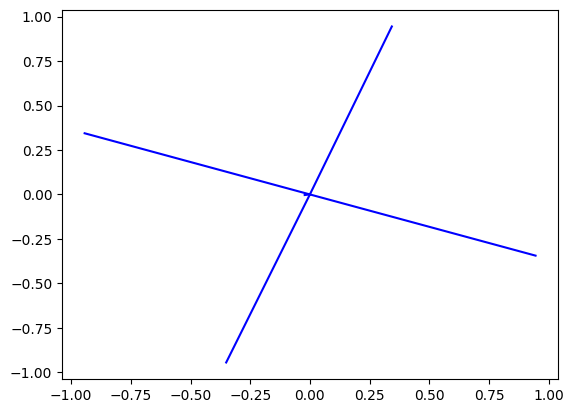

In [5]:
#@title Train TMS
n_features = 5
hidden_dim = 2
n_datapoints = 1024
sparsity = .075

batch_size = 12
learning_rate = .1
n_epochs = 1000

X_tms, Y_tms, dataloader_TMS = GenerateTMSData(
    num_features=n_features, num_datapoints=n_datapoints, sparsity=sparsity, batch_size=batch_size)
tms_model = Autoencoder(n_features, hidden_dim)
_, _, _ = TrainModel(tms_model, nn.MSELoss(), learning_rate, dataloader_TMS, n_epochs=n_epochs)


# Plot TMS representations.
en = copy.deepcopy(tms_model.W).detach().cpu().numpy()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

## 2-layer transformer




In [137]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
config = GPT2Config.from_pretrained('gpt2', n_layer=2)
gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
tokenizer.pad_token = tokenizer.eos_token
transformer_model = TransformerWrapper(gpt2, tokenizer)

# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if p!='transformer.h.1.ln_1.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,_ in transformer_model.named_parameters(): print(n)

768
transformer.h.1.ln_1.weight


In [8]:
# Load in data.
imdb_dataset = load_dataset("imdb", split="test[:1%]")
X_transformer= tokenize_and_concatenate(imdb_dataset, tokenizer, max_length = 24, add_bos_token=False)['tokens']
transformer_dataloader = DataLoader(X_transformer, batch_size=24, shuffle=True,
                                    generator=torch.Generator(device='cuda'))

# Eigenestimation

# Tests on Toy Models


## Xornet

In [106]:
n_u_vectors = 3
batch_size = 12
lambda_penalty = 1
repeats = 24
n_epochs = 100
learning_rate = .01

torch.cuda.empty_cache()
gc.collect()
eigenmodel_xornet = EigenEstimation(model_xornet, nn.MSELoss, n_u_vectors)

dataloader_xornet_eigen = DataLoader(
    einops.repeat(X_xornet, 's f -> (s r) f', r=repeats), batch_size=batch_size, shuffle=True,
    generator=torch.Generator(device=device))

TrainEigenEstimation(eigenmodel_xornet, dataloader_xornet_eigen, learning_rate, n_epochs, lambda_penalty)

# Clear cuda cache
torch.cuda.empty_cache()
gc.collect()


Epoch 0 - Total Loss: -1.815, High Hessian Loss: -1.982,  Basis Loss: 0.167
Epoch 10 - Total Loss: -4.499, High Hessian Loss: -4.537,  Basis Loss: 0.037
Epoch 20 - Total Loss: -4.518, High Hessian Loss: -4.526,  Basis Loss: 0.008
Epoch 30 - Total Loss: -4.521, High Hessian Loss: -4.525,  Basis Loss: 0.004
Epoch 40 - Total Loss: -4.522, High Hessian Loss: -4.524,  Basis Loss: 0.002
Epoch 50 - Total Loss: -4.523, High Hessian Loss: -4.525,  Basis Loss: 0.002
Epoch 60 - Total Loss: -4.523, High Hessian Loss: -4.525,  Basis Loss: 0.002
Epoch 70 - Total Loss: -4.523, High Hessian Loss: -4.525,  Basis Loss: 0.002
Epoch 80 - Total Loss: -4.523, High Hessian Loss: -4.525,  Basis Loss: 0.002
Epoch 90 - Total Loss: -4.523, High Hessian Loss: -4.525,  Basis Loss: 0.002


44

In [10]:
# Look at features
PrintFeatureVals(X_xornet, eigenmodel_xornet)

for f_idx in range(eigenmodel_xornet.n_u_vectors):
  sample, val = ActivatingExamples(X_xornet, eigenmodel_xornet, f_idx, 3)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s, '->', v)

[0. 0.] --> [0.57 0.03 0.66]
[0. 1.] --> [0.01 5.37 0.  ]
[1. 0.] --> [0.06 0.   6.83]
[1. 1.] --> [0.   0.32 2.71]
feature 0
[0. 0.] -> 0.5718627
[1. 0.] -> 0.056731805
[0. 1.] -> 0.014461935
feature 1
[0. 1.] -> 5.3656316
[1. 1.] -> 0.31909278
[0. 0.] -> 0.03373315
feature 2
[1. 0.] -> 6.8339252
[1. 1.] -> 2.7056665
[0. 0.] -> 0.6608974


## TMS

In [11]:
#@title Train Eigenmodel
n_u_vectors = 5
batch_size = 24
lambda_penalty = 1
n_epochs = 100
learning_rate = .01


dataloader = DataLoader(X_tms, batch_size=batch_size, shuffle=True,
                               generator=torch.Generator(device='cuda'))
eigenmodel_tms = EigenEstimation(tms_model, nn.MSELoss, n_u_vectors)
TrainEigenEstimation(eigenmodel_tms, dataloader, learning_rate, n_epochs, lambda_penalty)

Epoch 0 - Total Loss: -0.919, High Hessian Loss: -1.039,  Basis Loss: 0.119
Epoch 10 - Total Loss: -4.113, High Hessian Loss: -4.419,  Basis Loss: 0.306
Epoch 20 - Total Loss: -4.530, High Hessian Loss: -4.739,  Basis Loss: 0.209
Epoch 30 - Total Loss: -5.509, High Hessian Loss: -5.559,  Basis Loss: 0.050
Epoch 40 - Total Loss: -5.606, High Hessian Loss: -5.612,  Basis Loss: 0.005
Epoch 50 - Total Loss: -6.593, High Hessian Loss: -6.597,  Basis Loss: 0.004
Epoch 60 - Total Loss: -6.057, High Hessian Loss: -6.062,  Basis Loss: 0.005
Epoch 70 - Total Loss: -5.906, High Hessian Loss: -5.911,  Basis Loss: 0.005
Epoch 80 - Total Loss: -5.552, High Hessian Loss: -5.555,  Basis Loss: 0.003
Epoch 90 - Total Loss: -5.991, High Hessian Loss: -5.995,  Basis Loss: 0.004


In [12]:
#@title Look at features
X = X_tms[:10]
PrintFeatureVals(X_tms[:10], eigenmodel_tms)

for f_idx in range(eigenmodel_tms.n_u_vectors):
  sample, val = ActivatingExamples(X_tms[:100,], eigenmodel_tms, f_idx, 3)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s.round(3), '->', v.round(3))

[0.   0.   0.   0.16 0.  ] --> [2.33 2.13 0.   0.95 0.  ]
[0.   0.32 0.   0.   0.  ] --> [0.01 2.12 0.   0.87 2.39]
[0.  0.  0.8 0.  0. ] --> [0.02 2.49 0.   9.1  0.69]
[0.   0.   0.   0.01 0.36] --> [1.25 1.97 2.8  0.   0.  ]
[0.   0.   0.   0.   0.26] --> [0.   2.01 2.09 0.   0.  ]
[0.   0.   0.   0.   0.33] --> [0.   1.98 2.55 0.   0.  ]
[0.   0.78 0.   0.   0.35] --> [0.01 1.96 2.65 0.   7.05]
[0.   0.   0.   0.89 0.  ] --> [13.08  2.15  1.03  1.29  0.  ]
[0.   0.   0.   0.64 0.83] --> [8.68 1.79 8.08 0.03 0.  ]
[0.   0.   0.   0.47 0.  ] --> [5.81 2.14 0.87 1.09 0.  ]
feature 0
[0.    0.    0.    0.928 0.   ] -> 13.952
[0.    0.    0.    0.887 0.   ] -> 13.081
[0.324 0.    0.    0.867 0.   ] -> 12.937
feature 1
[0.    0.    0.925 0.    0.   ] -> 2.548
[0.    0.    0.902 0.    0.   ] -> 2.537
[0.    0.    0.797 0.    0.   ] -> 2.487
feature 2
[0.    0.    0.    0.    0.999] -> 9.692
[0.    0.    0.    0.    0.914] -> 8.531
[0.    0.    0.    0.    0.896] -> 8.296
feature 3
[0.    0

## 2L Transformer

In [147]:
#@title Train Eigenmodel
#model = transformer_model
n_u_vectors = 10
batch_size = 4
lambda_penalty = 1
n_epochs = 500
learning_rate = .1

torch.cuda.empty_cache()
gc.collect()

transformer_dataloader = DataLoader(X_transformer[::10, :5], batch_size=batch_size, shuffle=True,
                                    generator=torch.Generator(device='cuda'))
eigenmodel_transformer = EigenEstimation(transformer_model, KLDivergenceLoss, n_u_vectors)
TrainEigenEstimation(eigenmodel_transformer, transformer_dataloader, learning_rate, n_epochs, lambda_penalty)

Epoch 0 - Total Loss: -460179.521, High Hessian Loss: -902031.125,  Basis Loss: 441851.605


KeyboardInterrupt: 

In [148]:
torch.cuda.empty_cache()
gc.collect()

1305

In [149]:
with torch.no_grad():
    for i in range(n_u_vectors):
        print(f'-----{i}-----')
        PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[::10,:10], i,top_k=5, batch_size=4)

-----0-----


In [119]:
with torch.no_grad():
    PrintFeatureValsTransformer(eigenmodel_transformer, X_transformer[::100,:10], 4, 1)

I love sci-fi and am willing to put -> [-0. -0.  0.  0. -0. -0. -0. -0.  0. -0.]
 a bin, the character development is just as awful -> [-0. -0. -0.  0.  0.  0. -0.  0.  0. -0.]
 English accent off pat). The best that can be -> [-0.  0. -0.  0.  0. -0. -0. -0. -0. -0.]
 is apparently stalking Sara, a cynical shopkeeper who -> [-0. -0.  0.  0. -0. -0. -0.  0. -0. -0.]
 it!<|endoftext|>B -> [-0.  0.  0.  0. -0. -0.  0.  0.  0. -0.]
 my life. I trooped it out though with -> [-0.  0. -0. -0. -0. -0.  0. -0. -0. -0.]
 Manchester), pretty nymphomaniac architect Linda -> [-0. -0.  0. -0.  0. -0.  0.  0. -0.  0.]
 at all scared of her, for Tommy's just -> [-0. -0.  0. -0. -0. -0. -0.  0.  0.  0.]
angled up inside roaring fireplaces, strung up -> [-0. -0.  0.  0. -0. -0. -0. -0.  0. -0.]
, these are characters in an '80s horror -> [-0. -0. -0.  0. -0. -0. -0. -0. -0.  0.]
 he has played. Boy, is that false advertising -> [-0. -0.  0. -0. -0. -0.  0. -0.  0.  0.]
 with what appeared to be a heart

** leaving** a laughable, hollow husk.<br / ->  leaving (Value: 7265277952.000)
** whole** tribe sings it in the blazing sun speeding down ->  whole (Value: 7087225856.000)
** to** recover all the $77 million in just the ->  to (Value: 7053407232.000)
** to** shock the audiences. However, since the film ->  to (Value: 7053407232.000)
** to** go through with their plan they have to be ->  to (Value: 7053407232.000)


TransformerWrapper(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)